<a href="https://colab.research.google.com/github/appersaravanan/Semeter-2-Assignment-1/blob/master/custom_object_dectection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow_datasets as tfds
import tensorflow as tf
# !wget https://ai.stanford.edu/~jkrause/cars/car_devkit.tgz
# !wget http://imagenet.stanford.edu/internal/car196/cars_train.tgz
# (train_ds, val_ds, test_ds), metadata = tfds.load(
#     'cars196',
#     split=['train[:80%]'],
#     with_info=True
# )
from google.colab import drive
drive.mount('/content/drive')
# https://github.com/deanwetherby/tf_oda_stanford_cars

# https://towardsdatascience.com/how-to-train-your-own-object-detector-with-tensorflows-object-detector-api-bec72ecfe1d9
# https://github.com/Tony607/object_detection_demo


Mounted at /content/drive


In [2]:
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import densenet
from keras.models import Sequential, Model, load_model
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, Callback
from keras import regularizers
from keras import backend as K
from keras.applications import VGG16
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import  MaxPooling2D,UpSampling2D,Input,BatchNormalization,Conv2D,Activation,MaxPool2D,Flatten,Dense,GlobalAveragePooling2D,Lambda,Concatenate,GlobalMaxPooling2D,Add,multiply
from tensorflow.keras.models import Model,Sequential,load_model
from tensorflow.keras.optimizers import Adam,SGD
from tensorflow.keras.datasets import cifar10
import matplotlib.pyplot as plt
from keras.utils import np_utils
from keras.preprocessing import image as image_utils
from keras.applications.imagenet_utils import decode_predictions
from keras.applications.imagenet_utils import preprocess_input
from keras.applications import VGG16
import cv2,os,tempfile
import requests
from keras.preprocessing import image
from scipy.io import loadmat
import tensorflow as tf
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from tensorflow.keras.layers import  Reshape
import hashlib
import io
import logging
import csv
import PIL.Image


In [ ]:
img_width, img_height = 224, 224
nb_train_samples = 8144
nb_validation_samples = 4899
epochs = 10
batch_size = 64
n_classes = 196
path_base='/content/drive/MyDrive/semester_2_final_project/'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cp /content/drive/MyDrive/YOLOv4_weight/data/cars_train.tgz /content/drive/MyDrive/semester_2_final_project/data/training_set/
%cd /content/drive/MyDrive/semester_2_final_project/data/training_set/
!tar xvzf cars_train.tgz



In [ ]:
%cp /content/drive/MyDrive/semester_2_final_project/cars_test.zip /content/drive/MyDrive/semester_2_final_project/data/test_set/
%cd /content/drive/MyDrive/semester_2_final_project/data/test_set/
!sudo unzip cars_test.zip


In [ ]:
%cd /content/drive/MyDrive/semester_2_final_project/


/content/drive/MyDrive/semester_2_final_project


In [ ]:


!rm -f car_devkit.tgz
!wget https://ai.stanford.edu/~jkrause/cars/car_devkit.tgz
!tar xvzf car_devkit.tgz

--2021-04-29 16:40:50--  https://ai.stanford.edu/~jkrause/cars/car_devkit.tgz
Resolving ai.stanford.edu (ai.stanford.edu)... 171.64.68.10
Connecting to ai.stanford.edu (ai.stanford.edu)|171.64.68.10|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 330960 (323K) [application/x-gzip]
Saving to: ‘car_devkit.tgz’

car_devkit.tgz      100%[===================>] 323.20K  1.53MB/s    in 0.2s    

2021-04-29 16:40:51 (1.53 MB/s) - ‘car_devkit.tgz’ saved [330960/330960]

devkit/
devkit/cars_meta.mat
devkit/cars_train_annos.mat
devkit/cars_test_annos.mat
devkit/README.txt
devkit/train_perfect_preds.txt
devkit/eval_train.m


In [ ]:
# !wget http://imagenet.stanford.edu/internal/car196/cars_train.tgz

# !tar xvzf cars_train.tgz
# !rm -f cars_train.tgz
# !wget http://imagenet.stanford.edu/internal/car196/cars_test.tgz
# !tar xvzf cars_test.tgz
# !rm -f cars_test.tgz

In [ ]:
%cd {path_base}'data/inputs'
assert os.getcwd()=='/content/drive/MyDrive/semester_2_final_project/data/inputs', 'Directory should be "/content/drive/MyDrive/semester_2_final_project/data/inputs" instead of "{}"'.format(os.getcwd())
!rm -Rfv ./*
!pwd
annotsa = loadmat('/content/drive/MyDrive/semester_2_final_project/devkit/cars_meta.mat')
i=1
classes_name=[]
labelMap='';
for name in annotsa['class_names'][0]:
  dir_name=str(i)+'_'+str(name[0]).replace(' ','_')
  os.makedirs(dir_name)
  if i<10:
    classes_name.append(dir_name)  
    labelMap+=' item { \n \t id:'+ str(i) +' \n \t name:' +" '" + dir_name +"' \n } \n \n"
  i=i+1
labelMap



In [ ]:
f= open("/content/drive/MyDrive/semester_2_final_project/data/annotations/train_label_map_10.pbtxt","w+")
f.write(labelMap)
f.close()

In [44]:
import shutil
from shutil import copyfile

from_train_data_dir = '/content/drive/MyDrive/semester_2_final_project/data/training_set/cars_train'
to_directory ='/content/drive/MyDrive/semester_2_final_project/data/inputs'

annos = loadmat('/content/drive/MyDrive/semester_2_final_project/devkit/cars_train_annos.mat')
data = [[row.flat[0] for row in line] for line in annos['annotations'][0]]
columns = ['bbox_x1', 'bbox_y1', 'bbox_x2', 'bbox_y2', 'class', 'fname']
df_train = pd.DataFrame(data, columns=columns)
gp=df_train.groupby('class')
files=""
# for index,classes in gp:
    
#     files=classes['fname']
#     i=0
#     for name,file in files.items():
#         print(file)
#         copyfile('{}/{}'.format(from_train_data_dir,file),'{}/{}/{}'.format(to_directory,classes_name[index-1],file))
        
#         i=i+1


In [45]:
trimmed_data_set= df_train.loc[df_train['class']<10]

In [47]:
trimmed_data_set[trimmed_data_set['class']==1]

,bbox_x1,bbox_y1,bbox_x2,bbox_y2,class,fname
162,46,84,661,428,1,00163.jpg
461,5,8,83,58,1,00462.jpg
521,6,7,94,68,1,00522.jpg
706,26,32,677,418,1,00707.jpg
772,33,50,197,150,1,00773.jpg
886,6,9,124,89,1,00887.jpg
945,48,24,441,202,1,00946.jpg
1276,1,5,160,89,1,01277.jpg
1660,178,214,901,658,1,01661.jpg
1831,29,18,157,86,1,01832.jpg


In [ ]:
print(trimmed_data_set.columns.to_list())

columns = ['fname','bbox_x1', 'bbox_y1', 'bbox_x2', 'bbox_y2', 'class']
trimmed_data_set=trimmed_data_set[columns]
print(trimmed_data_set.columns.to_list())
print(trimmed_data_set.to_csv())
f= open("/content/drive/MyDrive/semester_2_final_project/data/annotations/train.csv","w+")
f.write(trimmed_data_set.to_csv())
f.close()



In [3]:
%cd /content/drive/MyDrive/semester_2_final_project/tf_model

!git clone --quiet https://github.com/tensorflow/models.git

!apt-get install -qq protobuf-compiler python-pil python-lxml python-tk

!pip install -q Cython contextlib2 pillow lxml matplotlib

!pip install -q pycocotools

!pip install tf_slim

%cd /content/drive/MyDrive/semester_2_final_project/tf_model/models/research
!protoc object_detection/protos/*.proto --python_out=.

import os
os.environ['PYTHONPATH'] += ':/content/drive/MyDrive/semester_2_final_project/tf_model/models:/content/drive/MyDrive/semester_2_final_project/tf_model/models/research/:/content/drive/MyDrive/semester_2_final_project/tf_model/models/research/slim/'

import sys
sys.path.append("/content/drive/MyDrive/semester_2_final_project/tf_model/models")

!python object_detection/builders/model_builder_tf2_test.py

/content/drive/MyDrive/semester_2_final_project/tf_model
fatal: destination path 'models' already exists and is not an empty directory.
Selecting previously unselected package python-bs4.
(Reading database ... 160690 files and directories currently installed.)
Preparing to unpack .../0-python-bs4_4.6.0-1_all.deb ...
Unpacking python-bs4 (4.6.0-1) ...
Selecting previously unselected package python-pkg-resources.
Preparing to unpack .../1-python-pkg-resources_39.0.1-2_all.deb ...
Unpacking python-pkg-resources (39.0.1-2) ...
Selecting previously unselected package python-chardet.
Preparing to unpack .../2-python-chardet_3.0.4-1_all.deb ...
Unpacking python-chardet (3.0.4-1) ...
Selecting previously unselected package python-six.
Preparing to unpack .../3-python-six_1.11.0-2_all.deb ...
Unpacking python-six (1.11.0-2) ...
Selecting previously unselected package python-webencodings.
Preparing to unpack .../4-python-webencodings_0.5-2_all.deb ...
Unpacking python-webencodings (0.5-2) ...
Se

In [ ]:
%cd /content/drive/MyDrive/semester_2_final_project/tf_model/models/research
!python object_detection/builders/model_builder_tf2_test.py

In [4]:

from object_detection.utils import dataset_util
from object_detection.utils import label_map_util

In [ ]:


from object_detection.utils import dataset_util
from object_detection.utils import label_map_util


SETS = ['train', 'test', 'merged']
def dict_to_tf_example(annotation, dataset_directory, label_map_dict):
  im_path = str(annotation['fname'])
  cls = int(annotation['class'])
  x1 = int(annotation['bbox_x1'])
  y1 = int(annotation['bbox_y1'])
  x2 = int(annotation['bbox_x2'])
  y2 = int(annotation['bbox_y2'])

  # read image
  full_img_path = os.path.join(dataset_directory, im_path)

  # read in the image and make a thumbnail of it
  max_size = 300, 300
  big_image = PIL.Image.open(full_img_path)
  width,height = big_image.size
  big_image.thumbnail(max_size, PIL.Image.ANTIALIAS)
  full_thumbnail_path = os.path.splitext(full_img_path)[0] + '_thumbnail.jpg'
  big_image.save(full_thumbnail_path)

  with tf.io.gfile.GFile(full_thumbnail_path, 'rb') as fid:
    encoded_jpg = fid.read()
  encoded_jpg_io = io.BytesIO(encoded_jpg)
  image = PIL.Image.open(encoded_jpg_io)

  xmin = []
  xmax = []
  ymin = []
  ymax = []

  # calculate box using original image coordinates
  xmin.append(max(0, x1 / width))
  xmax.append(min(1.0, x2 / width))
  ymin.append(max(0, y1 / height))
  ymax.append(min(1.0, y2 / height))

  # set width and height to thumbnail size for tfrecord ingest
  width,height = image.size

  classes = []
  classes_text = []

  label=''
  for name, val in label_map_dict.items():
    if val == cls: 
      label = name
      break

  classes_text.append(label.encode('utf8'))
  classes.append(label_map_dict[label])
  
  example = tf.train.Example(features=tf.train.Features(feature={
	'image/height': dataset_util.int64_feature(height),
	'image/width': dataset_util.int64_feature(width),
	'image/filename': dataset_util.bytes_feature(full_img_path.encode('utf8')),
	'image/source_id': dataset_util.bytes_feature(full_img_path.encode('utf8')),
	'image/encoded': dataset_util.bytes_feature(encoded_jpg),
	'image/format': dataset_util.bytes_feature('jpeg'.encode('utf8')),
	'image/object/bbox/xmin': dataset_util.float_list_feature(xmin),
	'image/object/bbox/xmax': dataset_util.float_list_feature(xmax),
	'image/object/bbox/ymin': dataset_util.float_list_feature(ymin),
	'image/object/bbox/ymax': dataset_util.float_list_feature(ymax),
	'image/object/class/text': dataset_util.bytes_list_feature(classes_text),
	'image/object/class/label': dataset_util.int64_list_feature(classes),
  }))
  return example 

data_dir = '/content/drive/MyDrive/semester_2_final_project/data/training_set/cars_train'
csv_file = '/content/drive/MyDrive/semester_2_final_project/data/annotations/train.csv'

writer =  tf.compat.v1.python_io.TFRecordWriter('/content/drive/MyDrive/semester_2_final_project/data/annotations/stanford_cars.tfrecord')
label_map_dict = label_map_util.get_label_map_dict('/content/drive/MyDrive/semester_2_final_project/data/annotations/train_label_map_10.pbtxt')
count=0;
with open(csv_file) as f:
  csv_reader = csv.DictReader(f)
  for row in csv_reader:
    tf_example = dict_to_tf_example(row, data_dir, label_map_dict)
    writer.write(tf_example.SerializeToString())
    count+=1;
    print(count)
writer.close()

In [ ]:
%cd /content/drive/MyDrive/semester_2_final_project/data/annotations
%cp stanford_cars.tfrecord  stanford_cars_test.tfrecord


/content/drive/MyDrive/semester_2_final_project/data/annotations


In [ ]:
import tensorflow as tf 
raw_dataset = tf.data.TFRecordDataset("/content/drive/MyDrive/semester_2_final_project/data/annotations/stanford_cars.tfrecord")

count=0;
for raw_record in raw_dataset:
    # example = tf.train.Example()
    # example.ParseFromString(raw_record.numpy())
    count+=1;
    print(count)

In [12]:
%cd /content/drive/MyDrive/semester_2_final_project/temp

import os
import shutil
import glob
import urllib.request
import tarfile
MODEL ='ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8'
MODEL_FILE = MODEL + '.tar.gz'
DOWNLOAD_BASE = 'http://download.tensorflow.org/models/object_detection/tf2/20200711/'
#http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz

#http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_mobilenet_v2_320x320_coco17_tpu-8.tar.gz
#http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_mobilenet_v1_fpn_640x640_coco17_tpu-8.tar.gz
#https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/tf2_detection_zoo.md


DEST_DIR = '/content/drive/MyDrive/semester_2_final_project/temp'

if not (os.path.exists(MODEL_FILE)):
    urllib.request.urlretrieve(DOWNLOAD_BASE + MODEL_FILE, MODEL_FILE)

!tar xvzf {MODEL_FILE}

/content/drive/MyDrive/semester_2_final_project/temp
ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/
ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/checkpoint/
ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/checkpoint/ckpt-0.data-00000-of-00001
ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/checkpoint/checkpoint
ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/checkpoint/ckpt-0.index
ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/pipeline.config
ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/saved_model/
ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/saved_model/saved_model.pb
ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/saved_model/variables/
ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/saved_model/variables/variables.data-00000-of-00001
ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/saved_model/variables/variables.index


In [19]:
!pip install lvis
!pip install tensorflow-addons
!pip install tf-nightly

     |████████████████████████████████| 456.8MB 22kB/s 
     |████████████████████████████████| 4.2MB 53.6MB/s 
     |████████████████████████████████| 5.9MB 53.2MB/s 
     |████████████████████████████████| 4.0MB 50.5MB/s 
     |████████████████████████████████| 471kB 55.0MB/s 
     |████████████████████████████████| 1.3MB 53.2MB/s 
     |████████████████████████████████| 3.9MB 47.8MB/s 
ERROR: tensorflow 2.4.1 has requirement gast==0.3.3, but you'll have gast 0.4.0 which is incompatible.
ERROR: tensorflow 2.4.1 has requirement grpcio~=1.32.0, but you'll have grpcio 1.37.1 which is incompatible.
ERROR: tensorflow 2.4.1 has requirement h5py~=2.10.0, but you'll have h5py 3.1.0 which is incompatible.
  Found existing installation: grpcio 1.32.0
    Uninstalling grpcio-1.32.0:
      Successfully uninstalled grpcio-1.32.0
  Found existing installation: gast 0.3.3
    Uninstalling gast-0.3.3:
      Successfully uninstalled gast-0.3.3
  Found existing installation: h5py 2.10.0
    Uninstalli

In [ ]:

# --checkpoint_dir=/content/drive/MyDrive/semester_2_final_project/temp/ssd_mobilenet_v1_fpn_640x640_coco17_tpu-8/checkpoint \
!python /content/drive/MyDrive/semester_2_final_project/tf_model/models/research/object_detection/model_main_tf2.py \
--pipeline_config_path=/content/drive/MyDrive/semester_2_final_project/temp/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/pipeline.config \
--model_dir=/content/drive/MyDrive/semester_2_final_project/temp/model_export_ssd_mobilenet_v2_fpnlite_320_GOD \
--num_train_steps=3000



In [ ]:
PIPELINE_CONFIG_PATH='/content/drive/MyDrive/semester_2_final_project/temp/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/pipeline.config '
MODEL_DIR='/content/drive/MyDrive/semester_2_final_project/temp/fine_tune_model'
!ls {MODEL_DIR}

checkpoint		    ckpt-2.data-00000-of-00001	ckpt-3.index
ckpt-1.data-00000-of-00001  ckpt-2.index		train
ckpt-1.index		    ckpt-3.data-00000-of-00001


In [27]:

!python /content/drive/MyDrive/semester_2_final_project/tf_model/models/research/object_detection/exporter_main_v2.py  \
--input_type image_tensor \
--pipeline_config_path /content/drive/MyDrive/semester_2_final_project/temp/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/pipeline.config \
--trained_checkpoint_dir  '/content/drive/MyDrive/semester_2_final_project/temp/model_export_ssd_mobilenet_v2_fpnlite_320_GOD' \
--output_directory /content/drive/MyDrive/semester_2_final_project/model_export2/model_export_ssd_mobilenet_v2_fpnlite_320_GOD

2021-05-02 18:48:22.817895: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2021-05-02 18:48:22.817952: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (09f938e92aef): /proc/driver/nvidia/version does not exist
2021-05-02 18:48:22.818323: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.map_fn(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.map_fn(fn, elems))
W0502 18:48:23.199578 140213621499776 deprecation.py:601]

In [ ]:
# !python /content/drive/MyDrive/semester_2_final_project/tf_model/models/research/object_detection/exporter_main_v2.py \
#  --input_type image_tensor \
#  --pipeline_config_path {PIPELINE_CONFIG_PATH} \
#  --trained_checkpoint_dir  '/content/drive/MyDrive/semester_2_final_project/temp/fine_tune_model' \
#  --output_directory /content/drive/MyDrive/semester_2_final_project/model_export1_image_tensor

In [28]:
import matplotlib
import matplotlib.pyplot as plt

import io
import scipy.misc
import numpy as np
from six import BytesIO
from PIL import Image, ImageDraw, ImageFont

import tensorflow as tf

from object_detection.utils import label_map_util
from object_detection.utils import config_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder

%matplotlib inline

In [32]:
def load_image_into_numpy_array(path):
  """Load an image from file into a numpy array.

  Puts image into numpy array to feed into tensorflow graph.
  Note that by convention we put it into a numpy array with shape
  (height, width, channels), where channels=3 for RGB.

  Args:
    path: the file path to the image

  Returns:
    uint8 numpy array with shape (img_height, img_width, 3)
  """
  img_data = tf.io.gfile.GFile(path, 'rb').read()
  image = Image.open(BytesIO(img_data))
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

# detect_fn =tf.saved_model.load('/content/drive/MyDrive/semester_2_final_project/model_export/saved_model')
detect_fn =tf.saved_model.load('/content/drive/MyDrive/semester_2_final_project/model_export2/model_export_ssd_mobilenet_v2_fpnlite_320_GOD/saved_model')
category_index = label_map_util.create_category_index_from_labelmap('/content/drive/MyDrive/semester_2_final_project/data/annotations/train_label_map_10.pbtxt',
                                                                    use_display_name=True)

In [ ]:
detect_fn.graph_debug_info

/content/drive/MyDrive/semester_2_final_project/data/training_set/cars_train/00002.jpg100
100
Done
/content/drive/MyDrive/semester_2_final_project/data/training_set/cars_train/00065.jpg100
100
Done
/content/drive/MyDrive/semester_2_final_project/data/training_set/cars_train/02050.jpg100
100
Done


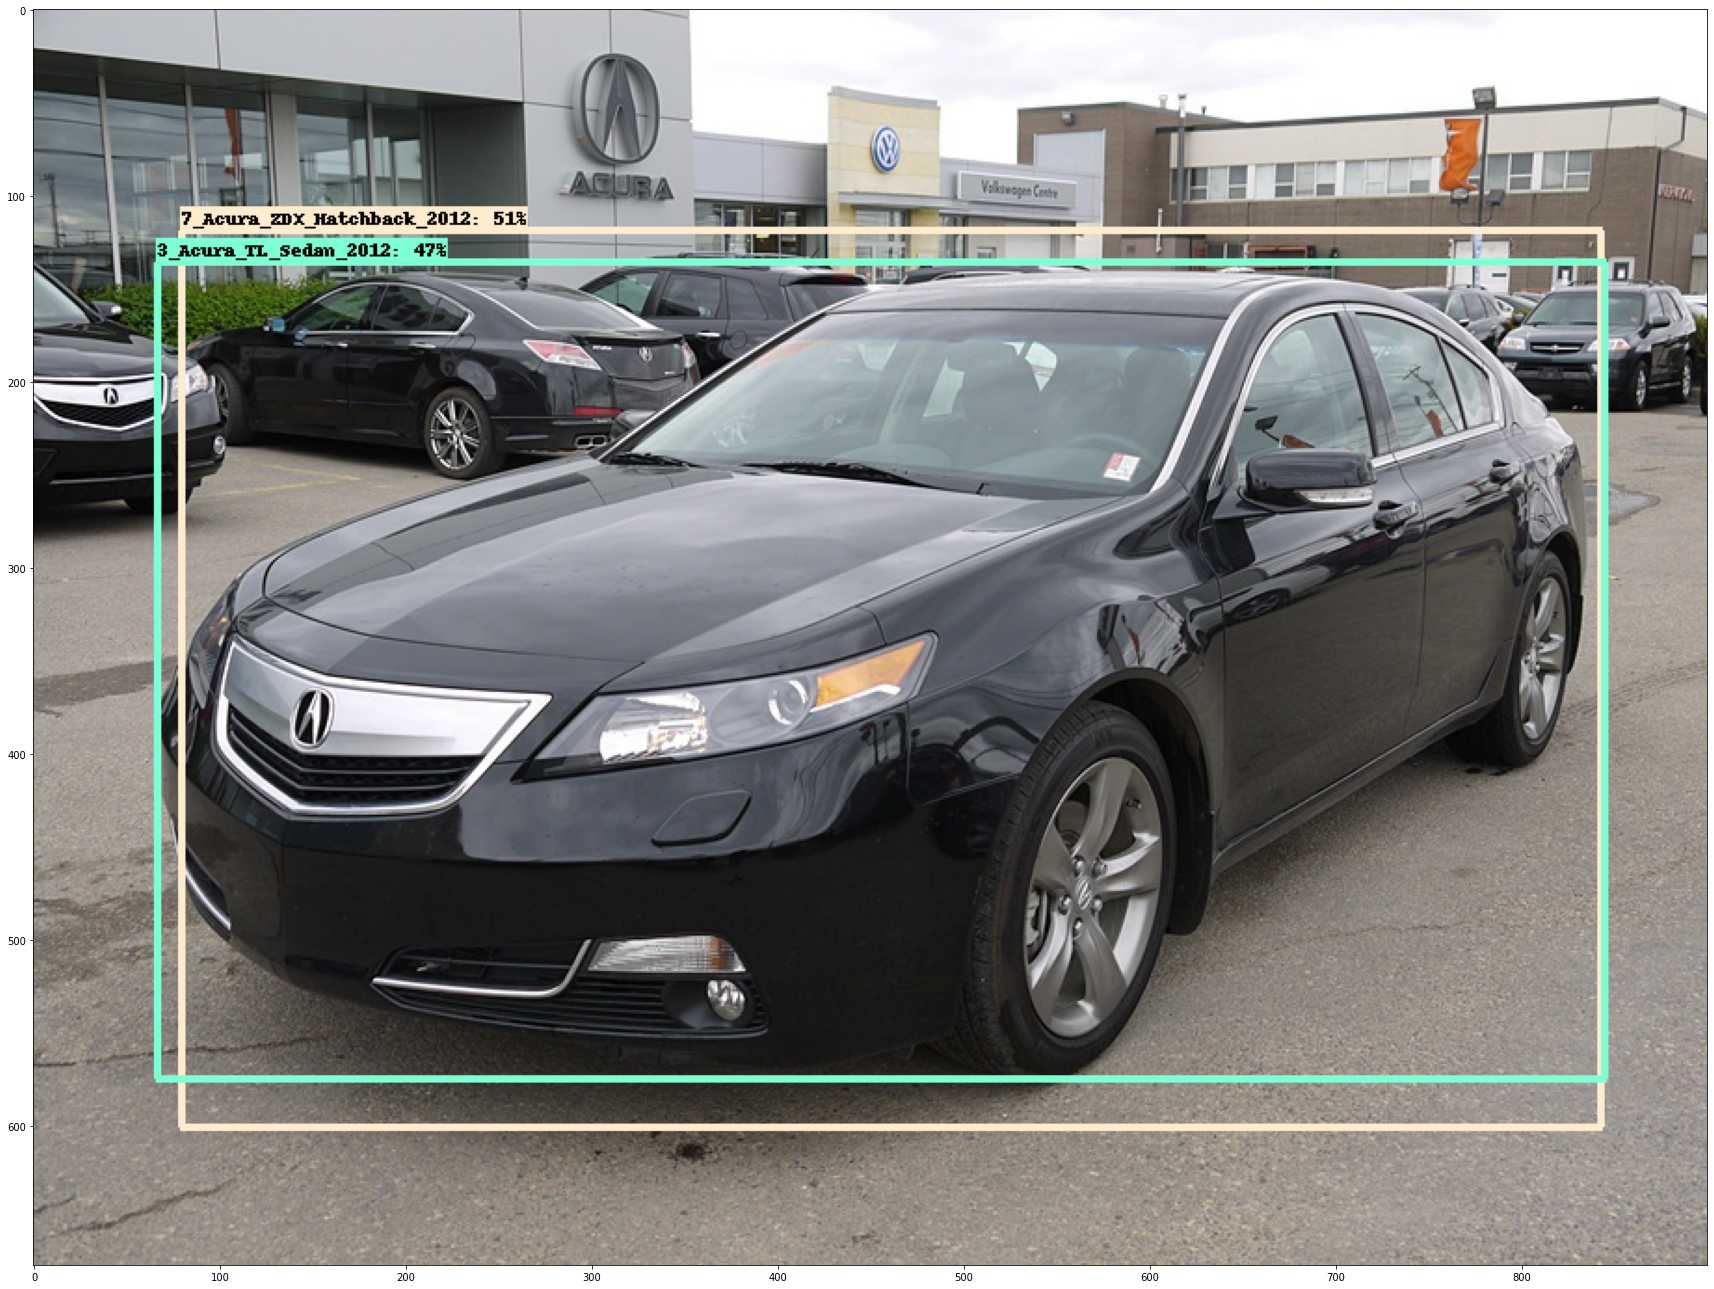

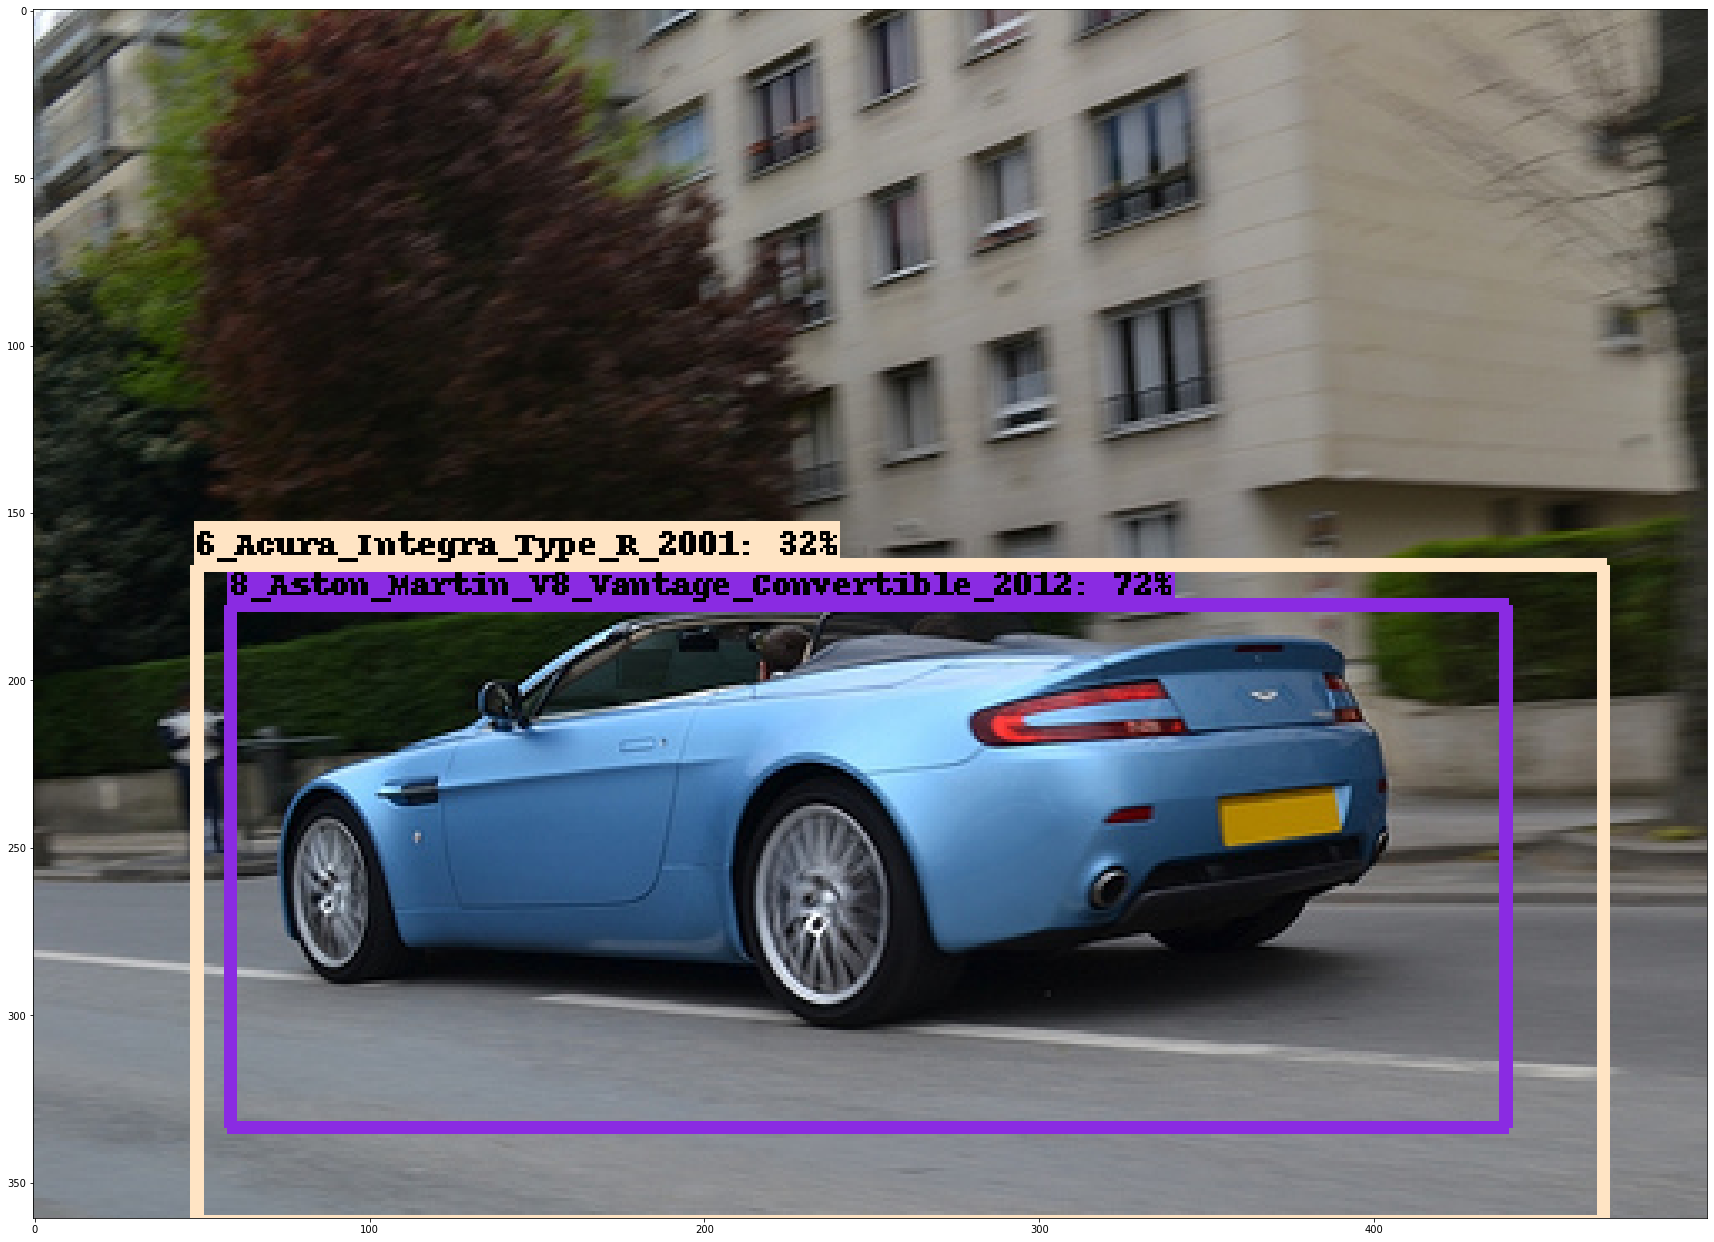

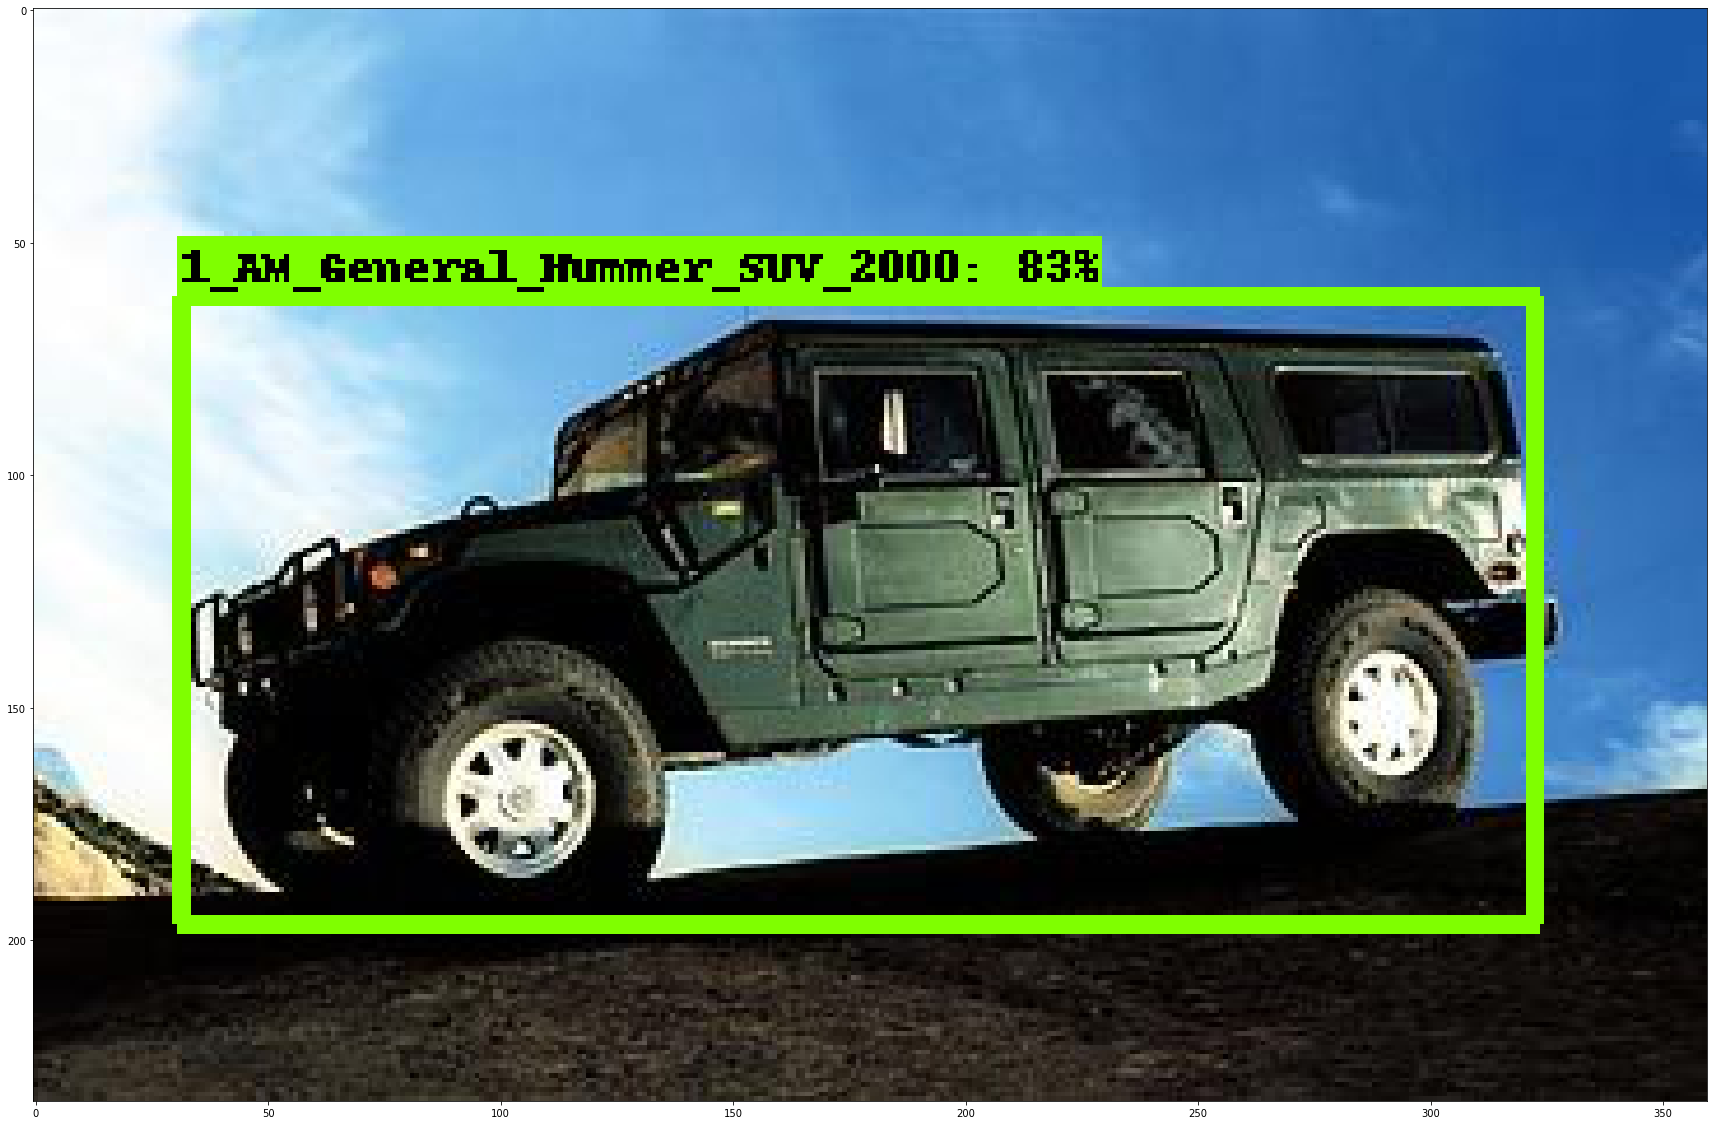

In [48]:
for image_path in ['00002.jpg','00065.jpg','02050.jpg']:

    print('/content/drive/MyDrive/semester_2_final_project/data/training_set/cars_train/{}'.format(image_path), end='')

    image_np = load_image_into_numpy_array('/content/drive/MyDrive/semester_2_final_project/data/training_set/cars_train/{}'.format(image_path))
     
    # image_np = np.asarray(Image.open(image_path)).astype('uint8')

    # Things to try:
    # Flip horizontally
    # image_np = np.fliplr(image_np).copy()

    # Convert image to grayscale
    # image_np = np.tile(
    #     np.mean(image_np, 2, keepdims=True), (1, 1, 3)).astype(np.uint8)

    # The input needs to be a tensor, convert it using `tf.convert_to_tensor`.
    input_tensor = tf.convert_to_tensor(image_np)
    # The model expects a batch of images, so add an axis with `tf.newaxis`.
    input_tensor = input_tensor[tf.newaxis, ...]

    # input_tensor = np.expand_dims(image_np, 0)
   
    detections = detect_fn(input_tensor)

    # All outputs are batches tensors.
    # Convert to numpy arrays, and take index [0] to remove the batch dimension.
    # We're only interested in the first num_detections.
    num_detections = int(detections.pop('num_detections'))
    print(num_detections)
    detections = {key: value[0, :num_detections].numpy()
                   for key, value in detections.items()}
    detections['num_detections'] = num_detections
    print(num_detections)

    # detection_classes should be ints.
    detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

    image_np_with_detections = image_np.copy()

    viz_utils.visualize_boxes_and_labels_on_image_array(
          image_np_with_detections,
          detections['detection_boxes'],
          detections['detection_classes'],
          detections['detection_scores'],
          category_index,
          use_normalized_coordinates=True,
          max_boxes_to_draw=200,
          min_score_thresh=.30,
          agnostic_mode=False)

    plt.figure(figsize=(30, 30))
    plt.imshow(image_np_with_detections)
    print('Done')
plt.show()

In [ ]:
configs = config_util.get_configs_from_pipeline_file('/content/drive/MyDrive/semester_2_final_project/model_export2/ssd_mobile_fpn_640_god/pipeline.config')
model_config = configs['model']

detection_model = model_builder.build(
      model_config=model_config, is_training=False)
ckpt = tf.compat.v2.train.Checkpoint(
      model=detection_model)
ckpt.restore(os.path.join('/content/drive/MyDrive/semester_2_final_project/model_export/checkpoint', 'ckpt-0')).expect_partial()

def get_model_detection_function(model):
  """Get a tf.function for detection."""

  @tf.function
  def detect_fn(image):
    """Detect objects in image."""

    image, shapes = model.preprocess(image)
    prediction_dict = model.predict(image, shapes)
    detections = model.postprocess(prediction_dict, shapes)

    return detections, prediction_dict, tf.reshape(shapes, [-1])

  return detect_fn

detect_fn = get_model_detection_function(detection_model)

In [ ]:
category_index = label_map_util.create_category_index_from_labelmap('/content/drive/MyDrive/semester_2_final_project/data/annotations/train_label_map_10.pbtxt',
                                                                    use_display_name=True)

In [ ]:
!python /content/drive/MyDrive/semester_2_final_project/tf_model/models/research/object_detection/packages/tf2/setup.py install


In [ ]:

for image_path in ['/content/drive/MyDrive/semester_2_final_project/data/training_set/cars_train/00002_thumbnail.jpg']:

    print('Running inference for {}... '.format(image_path), end='')

    image_np = np.asarray(Image.open(image_path)).astype('uint8')

    # Things to try:
    # Flip horizontally
    # image_np = np.fliplr(image_np).copy()

    # Convert image to grayscale
    # image_np = np.tile(
    #     np.mean(image_np, 2, keepdims=True), (1, 1, 3)).astype(np.uint8)

    # The input needs to be a tensor, convert it using `tf.convert_to_tensor`.
    input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
    # The model expects a batch of images, so add an axis with `tf.newaxis`.
    # input_tensor = input_tensor[tf.newaxis, ...]

    # input_tensor = np.expand_dims(image_np, 0)
    print('prediction')
    print(input_tensor)
    
    # image1, shapes = detection_model.preprocess(input_tensor)
    # prediction_dict = detection_model.predict(image1, shapes)
    # detections = detection_model.postprocess(prediction_dict, shapes)
    detections, predictions_dict, shapes = detect_fn(input_tensor)
    print(detections)
    print(tf.squeeze(detections['detection_boxes'], [0]))
    print(np.array(detections['detection_boxes'], [0]))
    label_id_offset = 1
    image_np_with_detections = image_np.copy()

    viz_utils.visualize_boxes_and_labels_on_image_array(
          image_np_with_detections,
          detections['detection_boxes'],
          detections['detection_classes'],
          detections['detection_scores'],
          category_index,
          use_normalized_coordinates=True,
          max_boxes_to_draw=200,
          min_score_thresh=.30,
          agnostic_mode=False)

    plt.figure()
    plt.imshow(image_np_with_detections)
    print('Done')
    plt.show()

In [ ]:


print(np.array(detections['detection_boxes']))

NotImplementedError: ignored

In [ ]:
y

NameError: ignored